# Bernstein-Varzirani Algorithm
The Bernstein-Varzirani algorithm solves the following problem:
1. Given an n-bit secret number x
2. There is an oracle holding the secret key that one can query with a number y, and the oracle will return $x \bullet y$, the bit-wise dot product modulo 2 of the two numbers. For example, given a 4-bit secret number $x=13$ with binary representation 1101 and $y=15$ with binary representation 1111, then $x \bullet y =$ 3 mod 2, which is 1
3. The question is: how many oracle queries does one need to figure out x?

With the classical approach, if we query the oracle with 1, 2(10), 4(100) and 8(1000), then we can figure out each bit of the secret key and thus we need four queries. For a general n-bit number, we need n queries. Surprisingly, in the quantum computing paradigm, the Bernstein-Varzirani algorithm needs only one measurement, regardless of the size of the secret number

In [1]:
import projectq
from projectq.backends import CircuitDrawer
from projectq.ops import H, Z, All, Measure, Barrier

from pathlib import Path

In [2]:
n = 3 #No. of qubits

## The classical approach

In [3]:
def query_oracle(y):
    """
    The oracle returns the bit-wise dot product modulo 2 
    of the secret key and y
    """
    x = 6 #secret key
    s = bin(x & y).count('1') % 2
    
    return s

In [4]:
b = ''.join([str(query_oracle(2**(k))) for k in reversed(range(n))])
print("Secret key is {} after {} tries".format(int(b, 2), n))

Secret key is 6 after 3 tries


## The quantum computing approach
There are five steps in the Bernstein-Varzirani circuit construction:
1. Initialize all qubits to 0 (This is the default value anyway)
2. Apply Hadamard transform to all qubits
3. Implement the oracle 
4. Apply Hadamard transform to all qubits
5. Measure the circuit

The workings of the Bernstein-Varzirani algorithm can only be understood by working through the mathematics. After step 2, the application of the Hadamard transform to all qubits results in
$$\begin{align} H^{\otimes n} |0\rangle = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} | y \rangle \end{align}$$
where $N = 2^n$

The oracle seeks to implement the following operation in step 3:
$$\begin{align} \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} | y \rangle \rightarrow \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} (-1)^{x \bullet y} | y \rangle \end{align}$$
The oracle effectively multiplies each superposition state $|y \rangle$ with -1 raised to the power of $x \bullet y$, the bit-wise inner product modulo 2. But why does the oracle implement this operation?

Using the identity (proof given below)
$$\begin{align} H^{\otimes n} |x\rangle = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} (-1)^{x \bullet y} | y \rangle \end{align}$$
If we further apply another Hadamard transform to all qubits in step 4, then $$ H^{\otimes n} H^{\otimes n} |x\rangle = H^{\otimes n} \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} (-1)^{x \bullet y} | y \rangle $$
i.e. $$ |x\rangle = H^{\otimes n} \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} (-1)^{x \bullet y} | y \rangle $$
since the Hadamard transform is symmetric and unitary (meaning that the transform is its own inverse). Thus measuring the circuit in step 5 will give the secret key.

Summarizing,
$$ H^{\otimes n} |0\rangle ^{\otimes n} \rightarrow \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} | y \rangle \rightarrow \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} (-1)^{x \bullet y} | y \rangle \rightarrow H^{\otimes n} \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} (-1)^{x \bullet y} | y \rangle = |x\rangle$$

### The oracle implementation
First note that in implementing
$$ \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} (-1)^{x \bullet y} | y \rangle = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} (-1)^{(x_{n-1} y_{n-1} \oplus \ldots \oplus x_0 y_0)} | y_{n-1}\ldots y_0\rangle $$
$$ = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} (-1)^{x_{n-1} y_{n-1}} (-1)^{x_{n-2} y_{n-2}} \ldots (-1)^{x_0 y_0}) | y_{n-1}\ldots y_0\rangle $$
the individual product ${x_{n-1} y_{n-1}, \ldots, x_0 y_0}$ only needs to be evaluated for bits in x that are 1. 

For the bits in x that are 1, we only introduce a minus sign for the bits in y that are 1 i.e.
$ |0 \rangle \rightarrow |0 \rangle$ and $ |1 \rangle \rightarrow -|1 \rangle$. This is precisely what the Z gate does. Thus the oracle can be implemented as: if a bit in x is 1, apply the Z gate to the corresponding bit in y.

In [5]:
def make_bv_circuit(engine, n):
    circuit = engine.allocate_qureg(n)
    All(H) | circuit
    Barrier | circuit
    
    # Oracle
    x = 6  # secret key
    for i in range(n):
        if x & 1:  # Only apply Z if the current bit of the secret key x is 1
            Z | circuit[i]
        x >>= 1  # Move the next bit to the 1 position
    Barrier | circuit
    
    All(H) | circuit
    All(Measure) | circuit
    engine.flush()

    return circuit

## Draw circuit diagram

In [6]:
drawing_engine = CircuitDrawer()
main_engine = projectq.MainEngine(drawing_engine)

In [7]:
circuit = make_bv_circuit(main_engine, n)

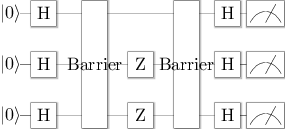

In [8]:
p = Path('diagram')
if not p.exists(): #if the diagram directory doesn't exist, create it
    p.mkdir()
with open('diagram/bv.tex', 'w') as f:
    latex = drawing_engine.get_latex() #get circuit diagram as latex
    f.write(latex) 
#Change the pdf scale to 1.8 from 0.8 to have better visual effect
!sed -i 's@tikzpicture\}\[scale=0.8@tikzpicture\}\[scale=1.8@g' diagram/bv.tex
!cd diagram; pdflatex bv.tex  > /dev/null #convert tex to latex, piping to /dev/null to silent output      

#Wand package needed to convert pdf to image
from wand.image import Image as WImage
img = WImage(filename='diagram/bv.pdf')
img

## Run circuit

In [9]:
main_engine = projectq.MainEngine()
circuit = make_bv_circuit(main_engine, n)
measurement = ''.join(str(int(c)) for c in reversed(circuit))
print('Measurement outcome:', measurement)
print('Secret key:', int(measurement, 2))

Measurement outcome: 110
Secret key: 6


## Proof of the key identity

$$\begin{align} H^{\otimes n} |x\rangle = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} (-1)^{x \bullet y} | y \rangle \end{align}$$ where $ N = 2^n $ and the $ \bullet$ operator denotes bitwise dot product modulo 2 i.e. $ x \bullet y = x_0y_0 \oplus x_1y_1 \oplus \ldots x_{N-1}y_{N-1}$ where $\oplus$ denotes the sum modulo 2 operation or the XOR operation. We prove this identity by induction.

Base case, n = 1:
$$ H |x_0\rangle = \frac{1}{\sqrt{2}} (|0\rangle + (-1)^{x_0}|1\rangle) = \frac{1}{\sqrt{2}} \sum_{y=0}^{1} (-1)^{x_0y} | y \rangle$$

Assuming n-1 (n > 1) is true i.e. $$ H^{\otimes (n-1)} |x_{n-2} \ldots x_0\rangle = \frac{1}{\sqrt{2^{n-1}}} \sum_{y=0}^{2^{n-1} - 1} (-1)^{(x_{n-2} \ldots x_0) \bullet (y_{n-2} \ldots y_0)} | y \rangle$$ 

$$ = \frac{1}{\sqrt{2^{n-1}}} \sum_{y=0}^{2^{n-1} - 1} (-1)^{(x_{n-2} y_{n-2} \oplus \ldots \oplus x_0 y_0)} | y \rangle$$ 

where $y = y_{n-2} \ldots y_0$ is the binary representation


Then $$ H^{\otimes n} |x_{n-1} \ldots x_0 \rangle =  \frac{1}{\sqrt{2}} (|0\rangle + (-1)^{x_{n-1}}|1\rangle) \times \frac{1}{\sqrt{2^{n-1}}} \sum_{y=0}^{2^{n-1} - 1} (-1)^{(x_{n-2} y_{n-2} \oplus \ldots \oplus x_0 y_0)} | y \rangle $$

$$ \begin{align} = \frac{1}{\sqrt{2^n}} \sum_{y=0}^{2^{n-1} - 1} (-1)^{(x_{n-2} y_{n-2} \oplus \ldots \oplus x_0 y_0)} |0\rangle| y \rangle + \frac{1}{\sqrt{2^n}} \sum_{y=0}^{2^{n-1} - 1} (-1)^{x_{n-1}} (-1)^{(x_{n-2} y_{n-2} \oplus \ldots \oplus x_0 y_0)} |1\rangle| y \rangle \end{align} $$

$$ \begin{align} = \frac{1}{\sqrt{2^n}} \sum_{y=0}^{2^{n-1} - 1} (-1)^{(x_{n-1}0 \oplus x_{n-2}y_{n-2} \oplus \ldots \oplus x_0y_0)} | y \rangle + \frac{1}{\sqrt{2^n}} \sum_{y=2^{n-1}}^{2^{n} - 1} (-1)^{(x_{n-1}1 \oplus x_{n-2}y_{n-2}\oplus \ldots \oplus x_0y_0)} | y \rangle \end{align}$$

$$ = \frac{1}{\sqrt{2^n}} \sum_{y=0}^{2^{n-1} - 1} (-1)^{(x_{n-1}x_{n-2} \ldots x_0) \bullet (0y_{n-2} \ldots y_0)} | y \rangle + \frac{1}{\sqrt{2^n}} \sum_{y=2^{n-1}}^{2^{n} - 1} (-1)^{(x_{n-1} \ldots x_0) \bullet (1y_{{n}-2} \ldots y_0)} | y \rangle $$

$$ = \frac{1}{\sqrt{2^{n}}} \sum_{y=0}^{2^{n} - 1} (-1)^{(x_{n-1} \ldots x_0) \bullet (y_{n-1} \ldots y_0)} | y \rangle $$